In [1]:
import string

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wordcloud

from nltk.stem.porter import PorterStemmer # We have various stemmers; let's utilize them.

%matplotlib inline

### Loading "spam_ham_dataset".

In [2]:
df = pd.read_csv('../dataset/original_data/spam_ham_dataset.csv')
df

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [3]:
df = df.drop(['Unnamed: 0'], axis = 1)
df

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...
5166,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,ham,Subject: industrial worksheets for august 2000...,0


### Separating the subject from the message and removing escape sequence.

In [4]:
test_preview = df['text'][0]
test_preview

"Subject: enron methanol ; meter # : 988291\r\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\r\nflow data provided by daren } .\r\nplease override pop ' s daily volume { presently zero } to reflect daily\r\nactivity you can obtain from gas control .\r\nthis change is needed asap for economics purposes ."

In [5]:
def subject_division(text):
    email_subjects = []
    email_texts = []
    for i in text:
        current_subject = ""
        current_text = ""
        is_subject = True
        for ch in i:
            if ch != '\r' and is_subject is True:
                current_subject += ch
            else:
                is_subject = False
                current_text += ch

        current_subject = current_subject.replace('Subject: ', '')
        current_text = current_text.replace('\r\n', '')
        
        email_subjects.append(current_subject)
        email_texts.append(current_text)

    return (email_subjects, email_texts)

In [6]:
email_subjects, email_texts = subject_division(df['text'])

for i in range(5):
    print(f"email_subjects = {email_subjects[i]}")
    print(f"email_texts = {email_texts[i]}\n")

email_subjects = enron methanol ; meter # : 988291
email_texts = this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminaryflow data provided by daren } .please override pop ' s daily volume { presently zero } to reflect dailyactivity you can obtain from gas control .this change is needed asap for economics purposes .

email_subjects = hpl nom for january 9 , 2001
email_texts = ( see attached file : hplnol 09 . xls )- hplnol 09 . xls

email_subjects = neon retreat
email_texts = ho ho ho , we ' re around to that most wonderful time of the year - - - neon leaders retreat time !i know that this time of year is extremely hectic , and that it ' s tough to think about anything past the holidays , but life does go on past the week of december 25 through january 1 , and that ' s what i ' d like you to think about for a minute .on the calender that i handed out at the beginning of the fall semester , the retreat was scheduled for the weekend of january 5 - 6 . but because o

### Label preparation.

Note:  
$spam = 1$  
$ham = 0$

In [7]:
df = df.drop(['label'], axis = 1)
df = df.rename(columns={'label_num': 'label'})
df

,text,label
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...
5166,Subject: put the 10 on the ft\r\nthe transport...,0
5167,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,Subject: industrial worksheets for august 2000...,0


#### Making changes.

In [8]:
df['text'] = email_texts
df['subject'] = email_subjects
df = df[['subject', 'text', 'label']] # Changed the order of columns
df

,subject,text,label
0,enron methanol ; meter # : 988291,this is a follow up to the note i gave you on ...,0
1,"hpl nom for january 9 , 2001",( see attached file : hplnol 09 . xls )- hplno...,0
2,neon retreat,"ho ho ho , we ' re around to that most wonderf...",0
3,"photoshop , windows , office . cheap . main tr...",abasements darer prudently fortuitous undergon...,1
4,re : indian springs,this deal is to book the teco pvr revenue . it...,0
...,...,...,...
5166,put the 10 on the ft,the transport volumes decreased from 25000 to ...,0
5167,3 / 4 / 2000 and following noms,hpl can ' t take the extra 15 mmcf / d over th...,0
5168,calpine daily gas nomination,">>julie , as i mention earlier we hope to star...",0
5169,industrial worksheets for august 2000 activity,attached are the worksheets for august 2000 ac...,0


<hr>

### Text preprocessing.

1. Removing Non-ASCII Characters.

In [9]:
def remove_NonASCII(text):
    for ch in text:
        if not ch in string.ascii_letters:
            text = text.replace(ch, ' ')

    return text

2. Removing short words (length less than or equal to *len_min_ch* characters) and converting the text to lowercase.

In [10]:
len_min_ch = 2

def remove_short_words(text):
    words = text.lower().split()
    text = ' '.join([word for word in words if len(word) > len_min_ch])

    return text

3. Removing stopwords.

Before the first usage, make sure stopwords are downloaded.  
Execute this command at least once.

In [11]:
# nltk.download('stopwords')

Stopwords are taken from the nltk and wordcloud modules, and then combined.

In [12]:
stop_words_n1 = set(nltk.corpus.stopwords.words('english'))
stop_words_n2 = set(wordcloud.STOPWORDS)
stop_words = set.union(stop_words_n1, stop_words_n2)

print(f"Number of words from the nltk module: {len(stop_words_n1)}")
print(f"Number of words from the wordcloud module: {len(stop_words_n2)}")
print(f"Number of stopwords after merging: {len(stop_words)}")
print(f"Number of words that are common in both sets: {len(stop_words_n2) + len(stop_words_n1) - len(stop_words)}")

Number of words from the nltk module: 179
Number of words from the wordcloud module: 192
Number of stopwords after merging: 227
Number of words that are common in both sets: 144


a about above after again against ain all also am an and any are aren aren't as at be because been before being below between both but by can can't cannot com could couldn couldn't d did didn didn't do does doesn doesn't doing don don't down during each else ever few for from further get had hadn hadn't has hasn hasn't have haven haven't having he he'd he'll he's hence her here here's hers herself him himself his how how's however http i i'd i'll i'm i've if in into is isn isn't it it's its itself just k let's like ll m ma me mightn mightn't more most mustn mustn't my myself needn needn't no nor not now o of off on once only or other otherwise ought our ours ourselves out over own r re s same shall shan shan't she she'd she'll she's should should've shouldn shouldn't since so some such t than that that'll that's the their theirs them themselves then there there's therefore these they they'd they'll they're they've this those through to too under until up ve very was wasn wasn't we we'd

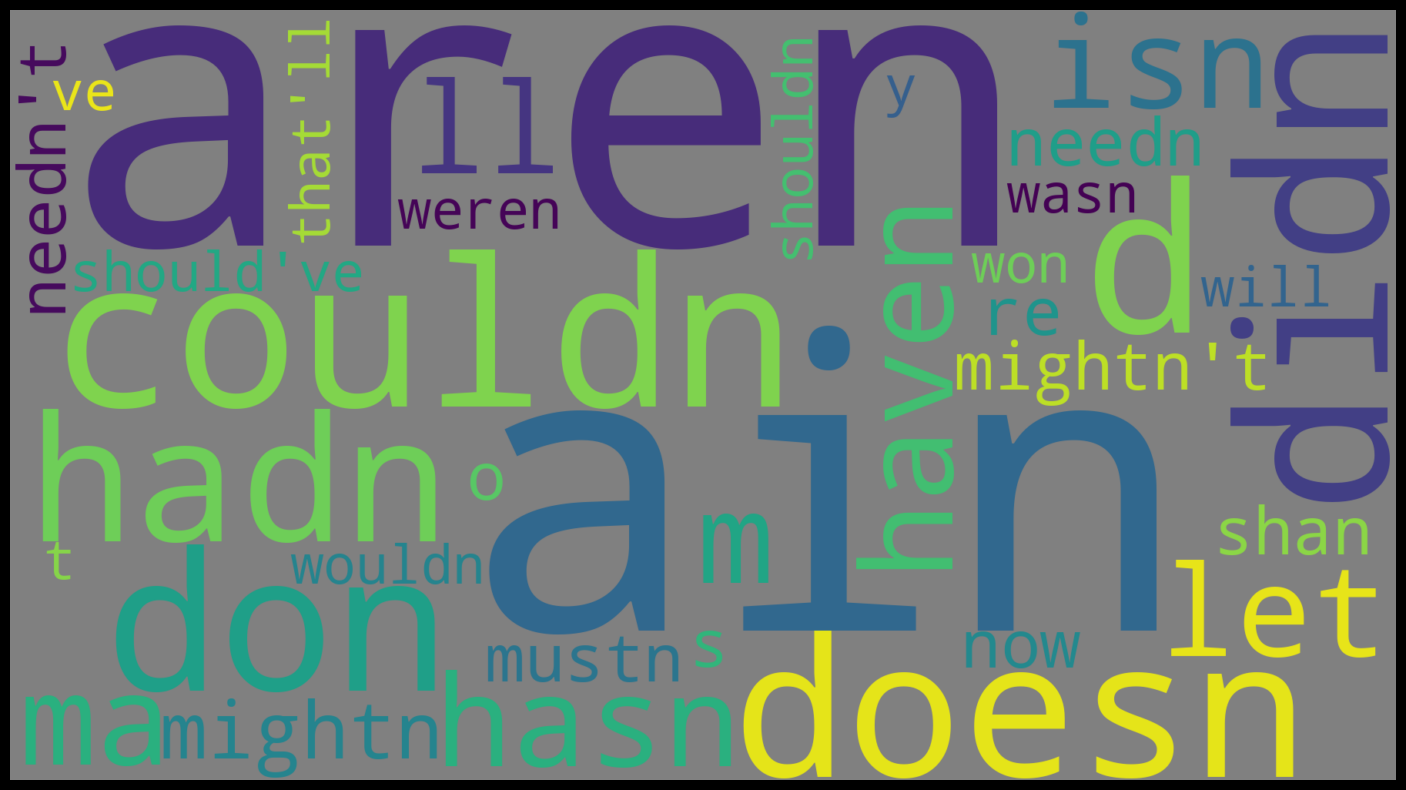

In [13]:
# Converting set elements to a string while preserving sorting order
stop_words = ' '.join(sorted(str(stop_word) for stop_word in stop_words))

print(stop_words)
print(type(stop_words))

# Generating word cloud (word_cloud)
word_cloud = wordcloud.WordCloud(collocations=False, background_color='grey', width=1800, height=1000).generate(stop_words)

# Displaying the word cloud image using plt.imshow
plt.figure(figsize=(20,10), facecolor='black')
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")# Turning off axes
plt.show()

In [14]:
list_stop_words = stop_words.split()
def remove_stopwords(text, list_stop_words=list_stop_words):
    text = text.split()
    text = [word for word in text if word not in list_stop_words]
    text = ' '.join(text)

    return text

4. Stemming.

In [15]:
stemmer = PorterStemmer()
def stemming(text):
    words = text.lower().split()
    text = ' '.join([stemmer.stem(word) for word in words])

    return text

Assembling the pipeline.

In [16]:
def pipeline(text):
    text = remove_NonASCII(text)
    text = remove_short_words(text)
    text = remove_stopwords(text)
    text = stemming(text)

    return text

<hr>

### Applying text preprocessing to the dataset.

In [17]:
# Apply the pipeline function to the 'subject' and 'text' columns, storing the results in new Series.
subject_after_pipeline = df['subject'].apply(pipeline)
text_after_pipeline = df['text'].apply(pipeline)

# Set names for the new Series to use them as column names.
subject_after_pipeline.name = 'subject_after_pipeline'
text_after_pipeline.name = 'text_after_pipeline'

# Drop the original 'subject' and 'text' columns from the DataFrame.
df = df.drop(['subject'], axis = 1)
df = df.drop(['text'], axis = 1)

# Concatenate the new Series with the original DataFrame along the column axis.
df = pd.concat([subject_after_pipeline, text_after_pipeline, df], axis=1)

# Display the result.
df

,subject_after_pipeline,text_after_pipeline,label
0,enron methanol meter,follow note gave monday preliminaryflow data p...,0
1,hpl nom januari,see attach file hplnol xl hplnol xl,0
2,neon retreat,around wonder time year neon leader retreat ti...,0
3,photoshop window offic cheap main trend,abas darer prudent fortuit undergonelightheart...,1
4,indian spring,deal book teco pvr revenu understand tecojust ...,0
...,...,...,...
5166,put,transport volum decreas oncontract thank ami f...,0
5167,follow nom,hpl take extra mmcf weekend tri next week nom ...,0
5168,calpin daili ga nomin,juli mention earlier hope start unit afternoon...,0
5169,industri worksheet august activ,attach worksheet august activ threediffer work...,0


### Saving the dataset.

In [18]:
df.to_csv('../dataset/model_data/spam_ham_dataset_prepared.csv')

<hr>

### Printing WordCloud for Emails.

Spam subject.

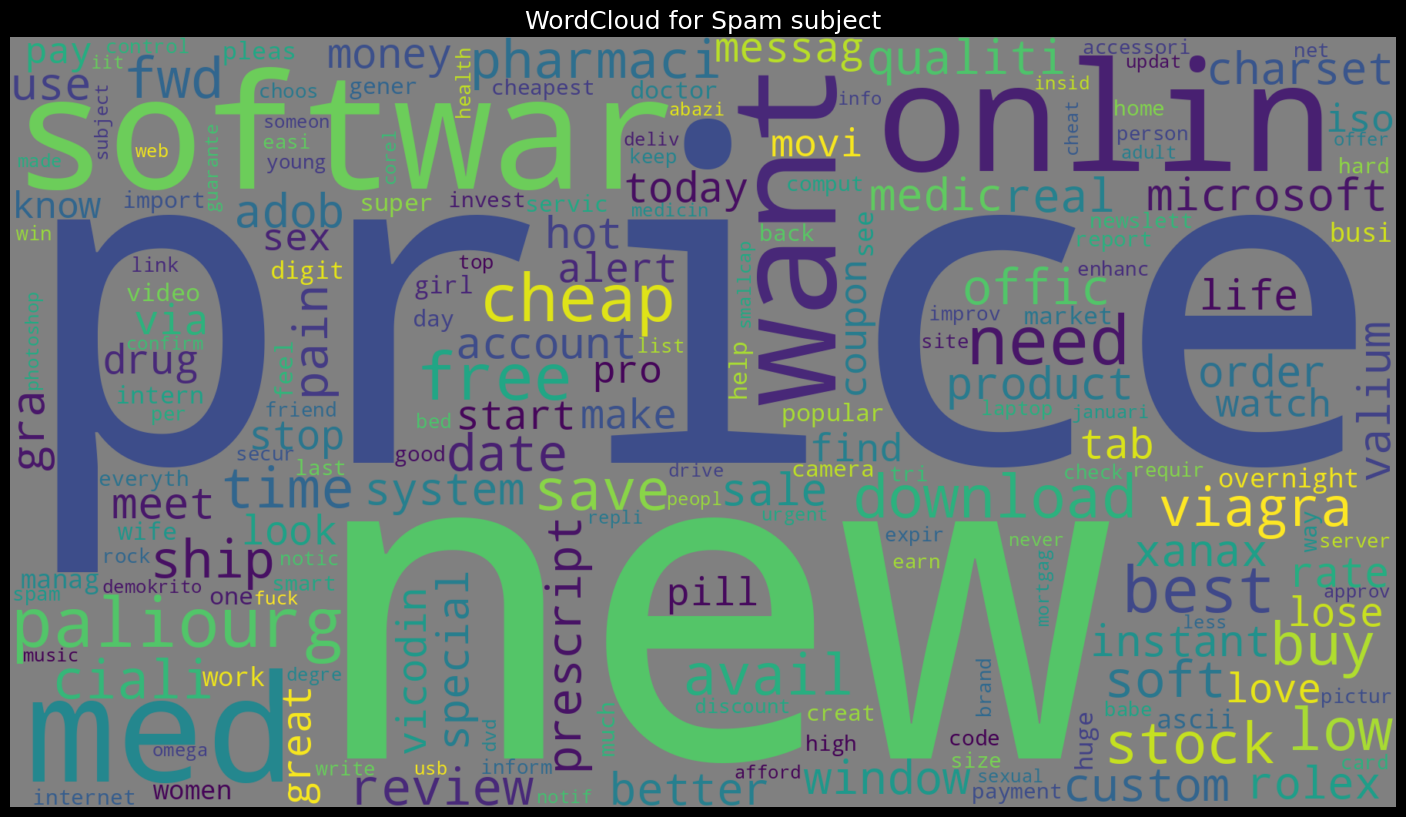

In [19]:
# Generating word cloud (word_cloud)
word_cloud = wordcloud.WordCloud(collocations=False, background_color='grey', width=1800, height=1000).generate(' '.join(df.loc[df['label']==1, 'subject_after_pipeline']))

# Displaying the word cloud image using plt.imshow
plt.figure(figsize=(20,10), facecolor='black')
plt.imshow(word_cloud, interpolation='bilinear')
plt.title('WordCloud for Spam subject', size=18, color='w')
plt.axis("off")# Turning off axes
plt.show()

Spam text.

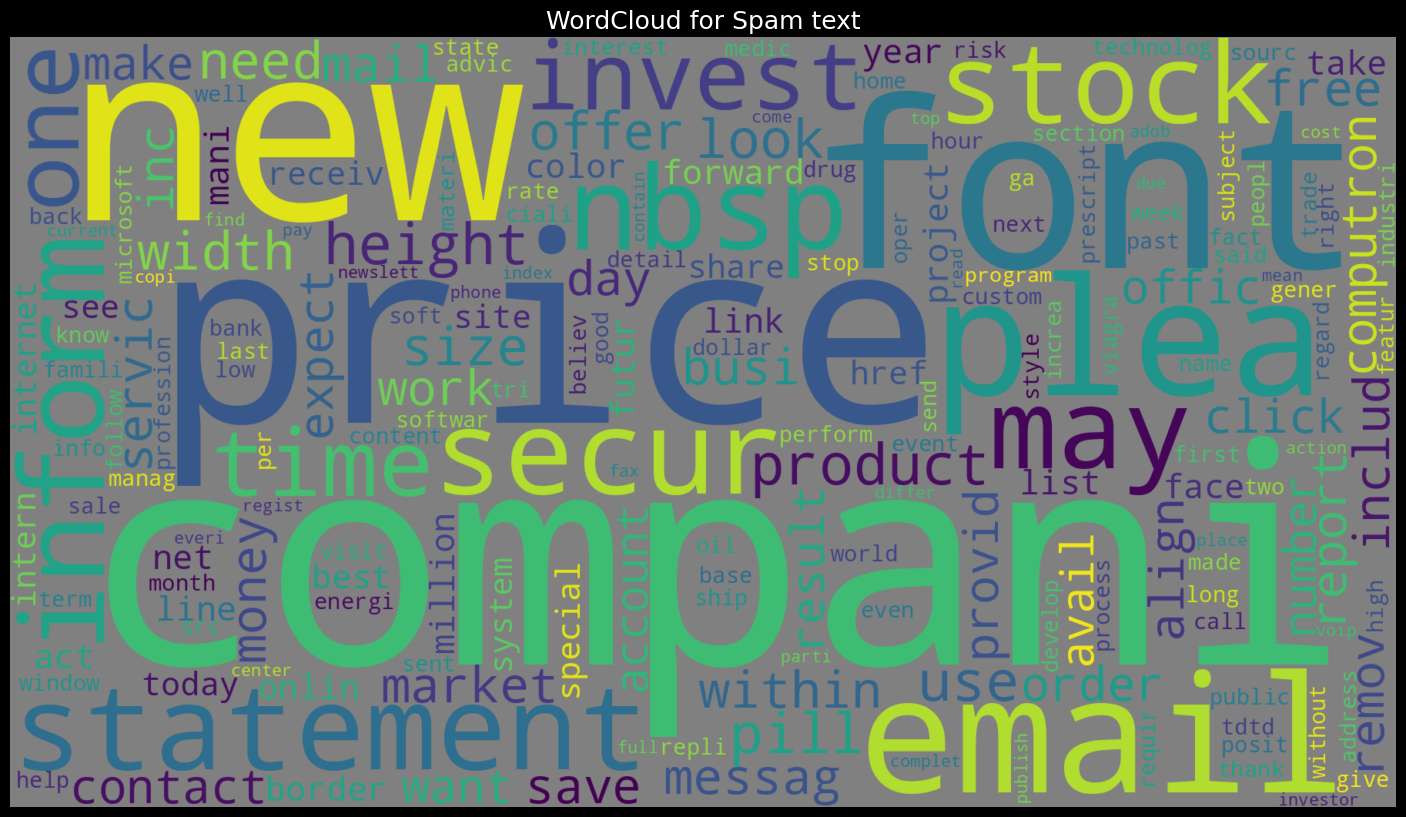

In [20]:
# Generating word cloud (word_cloud)
word_cloud = wordcloud.WordCloud(collocations=False, background_color='grey', width=1800, height=1000).generate(' '.join(df.loc[df['label']==1, 'text_after_pipeline']))

# Displaying the word cloud image using plt.imshow
plt.figure(figsize=(20,10), facecolor='black')
plt.imshow(word_cloud, interpolation='bilinear')
plt.title('WordCloud for Spam text', size=18, color='w')
plt.axis("off")# Turning off axes
plt.show()

Ham Subject.

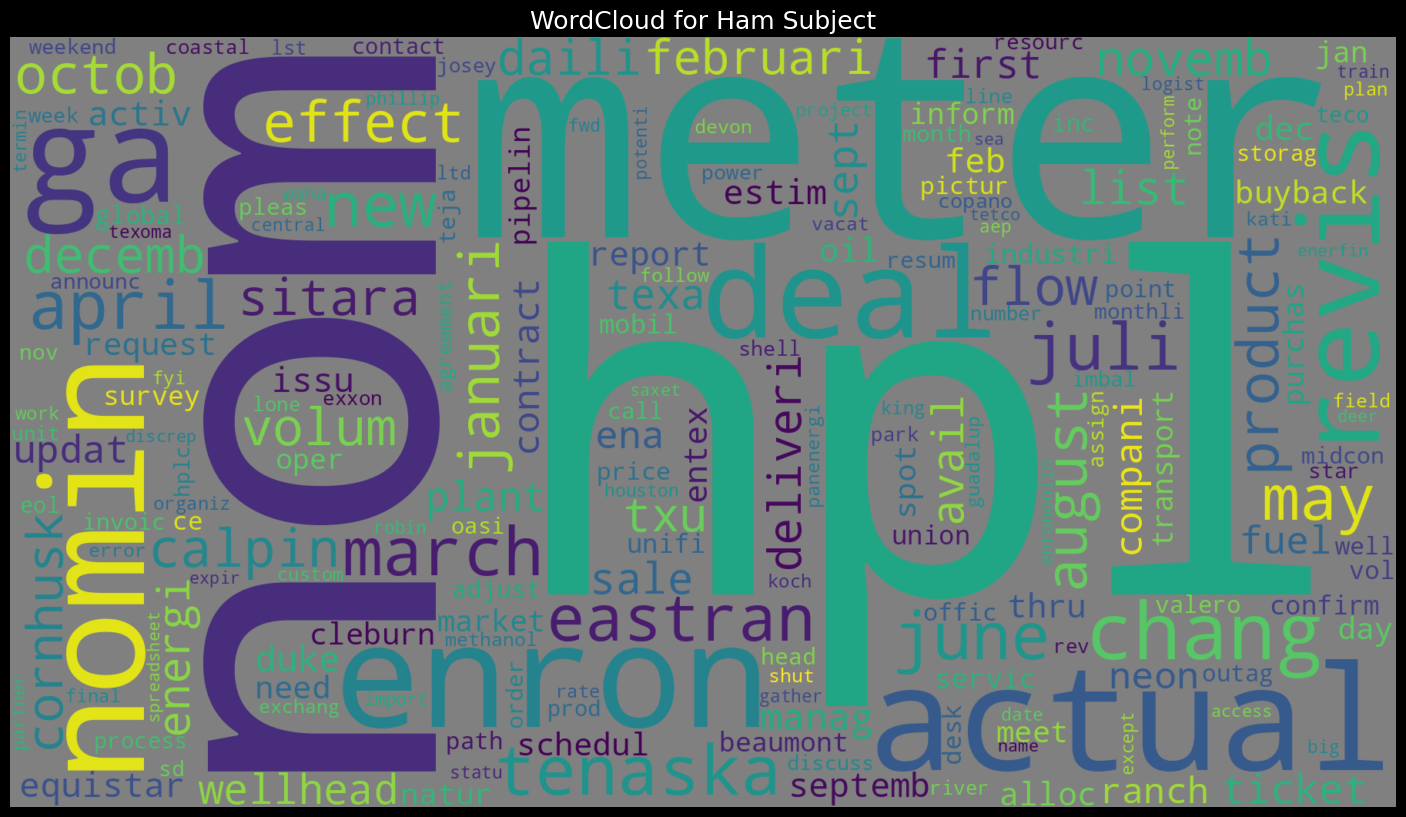

In [21]:
# Generating word cloud (word_cloud)
word_cloud = wordcloud.WordCloud(collocations=False, background_color='grey', width=1800, height=1000).generate(' '.join(df.loc[df['label']==0, 'subject_after_pipeline']))

# Displaying the word cloud image using plt.imshow
plt.figure(figsize=(20,10), facecolor='black')
plt.imshow(word_cloud, interpolation='bilinear')
plt.title('WordCloud for Ham Subject', size=18, color='w')
plt.axis("off")# Turning off axes
plt.show()

Ham text.

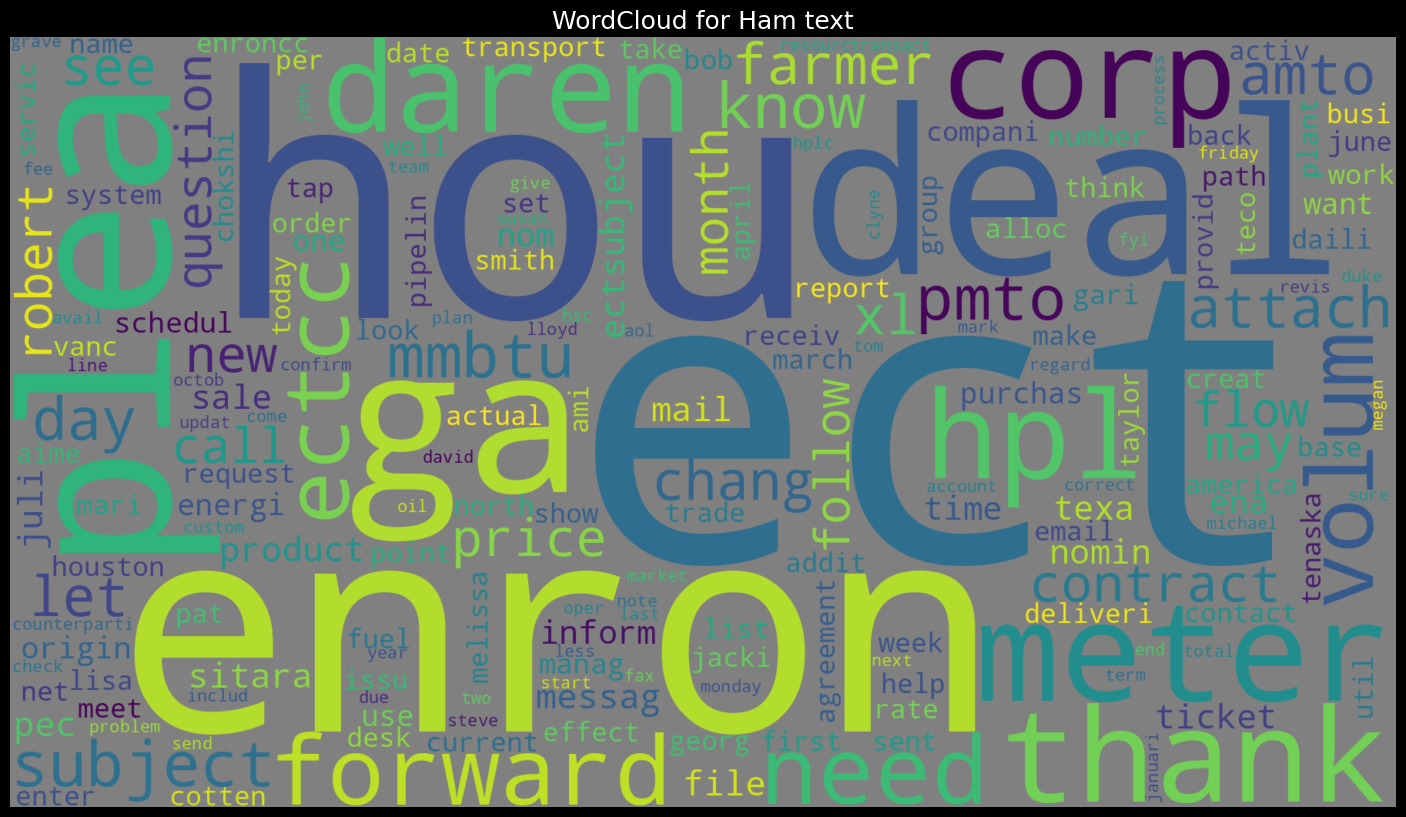

In [22]:
# Generating word cloud (word_cloud)
word_cloud = wordcloud.WordCloud(collocations=False, background_color='grey', width=1800, height=1000).generate(' '.join(df.loc[df['label']==0, 'text_after_pipeline']))

# Displaying the word cloud image using plt.imshow
plt.figure(figsize=(20,10), facecolor='black')
plt.imshow(word_cloud, interpolation='bilinear')
plt.title('WordCloud for Ham text', size=18, color='w')
plt.axis("off")# Turning off axes
plt.show()

<hr>

### Visualization of the Percentage of Spam and Ham.

Total number of emails: 5171 -> 100%
Total number of ham emails: 3672 -> 71.01%
Total number of spam emails: 1499 -> 28.99%


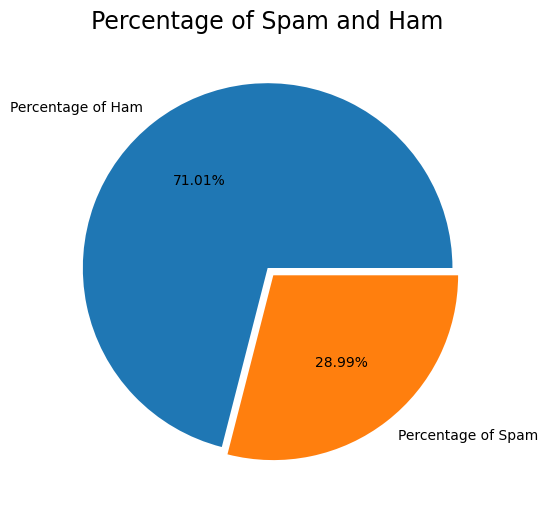

In [23]:
count_ham = df[df['label']==0].count().iloc[0]
count_spam = df[df['label']==1].count().iloc[0]

count_ham_in_percentage = round((count_ham/(count_ham + count_spam))*100, 2)
count_spum_in_percentage = round((count_spam/(count_ham + count_spam))*100, 2)

print(f"Total number of emails: {count_ham + count_spam} -> 100%")
print(f"Total number of ham emails: {count_ham} -> {count_ham_in_percentage}%")
print(f"Total number of spam emails: {count_spam} -> {count_spum_in_percentage}%")

fig, ax = plt.subplots(figsize = (10,6))
ax.set_title("Percentage of Spam and Ham", fontsize=17)
ax.pie([count_ham_in_percentage, count_spum_in_percentage], explode=[0.0, 0.05], labels=["Percentage of Ham", "Percentage of Spam"], autopct='%1.2f%%')
plt.show()

##### Saving the dataframe with SPAM-to-total-emails and HAM-to-total-emails ratios.

In [24]:
email_ratios = pd.DataFrame({'ham': [count_ham/(count_ham + count_spam)],
                             'spam': [count_spam/(count_ham + count_spam)]},
                            index=['ratios-to-total-emails'])

email_ratios.to_csv('../dataset/model_data/email_ratios.csv')
email_ratios

,ham,spam
ratios-to-total-emails,0.710114,0.289886


<hr>

### Frequency Analysis of Words.

In [25]:
def calculate_frequency_words(all_words):
    unique_words = list(set(all_words))
    frequency_words = dict.fromkeys(unique_words, 0)

    for word in all_words:
        frequency_words[word] += 1

    return frequency_words

In [26]:
words_subject_text = ' '.join(df['text_after_pipeline']).split() + ' '.join(df['subject_after_pipeline']).split()
words_ham_subject_text = ' '.join(df.loc[df['label']==0, 'text_after_pipeline']).split() + ' '.join(df.loc[df['label']==0, 'subject_after_pipeline']).split()
words_spam_subject_text = ' '.join(df.loc[df['label']==1, 'text_after_pipeline']).split() + ' '.join(df.loc[df['label']==1, 'subject_after_pipeline']).split()

unique_words_subject_text = list(set(words_subject_text))
unique_words_ham_subject_text = list(set(words_ham_subject_text))
unique_words_spam_subject_text = list(set(words_spam_subject_text))

print(f"Total words in all emails (including subject) {len(words_subject_text)}, with the number of unique words {len(unique_words_subject_text)}.")
print(f"Total words in ham emails (including subject) {len(words_ham_subject_text)}, with the number of unique words {len(unique_words_ham_subject_text)}.")
print(f"Total words in spam emails (including subject) {len(words_spam_subject_text)}, with the number of unique words {len(unique_words_spam_subject_text)}.\n")

Total words in all emails (including subject) 446085, with the number of unique words 55352.
Total words in ham emails (including subject) 289802, with the number of unique words 23400.
Total words in spam emails (including subject) 156283, with the number of unique words 37979.



In [27]:
# Determining word frequencies
frequency_words_subject_text = calculate_frequency_words(words_subject_text)
frequency_words_ham_subject_text = calculate_frequency_words(words_ham_subject_text)
frequency_words_spam_subject_text = calculate_frequency_words(words_spam_subject_text)

# Sorting word frequencies in descending order
frequency_words_subject_text = dict(sorted(frequency_words_subject_text.items(), key=lambda item: item[1], reverse=True))
frequency_words_ham_subject_text = dict(sorted(frequency_words_ham_subject_text.items(), key=lambda item: item[1], reverse=True))
frequency_words_spam_subject_text = dict(sorted(frequency_words_spam_subject_text.items(), key=lambda item: item[1], reverse=True))

# Preparing a dictionary for conversion into a dataframe.
frequency_words_subject_text = {key: [value] for key, value in frequency_words_subject_text.items()}
frequency_words_ham_subject_text = {key: [value] for key, value in frequency_words_ham_subject_text.items()}
frequency_words_spam_subject_text = {key: [value] for key, value in frequency_words_spam_subject_text.items()}

# Creating a DataFrame and Transposing It
frequency_words_subject_text = pd.DataFrame(frequency_words_subject_text).T
frequency_words_ham_subject_text = pd.DataFrame(frequency_words_ham_subject_text).T
frequency_words_spam_subject_text = pd.DataFrame(frequency_words_spam_subject_text).T

# Renaming a column in a dataframe.
frequency_words_subject_text = frequency_words_subject_text.rename(columns={0: 'frequency'})
frequency_words_ham_subject_text = frequency_words_ham_subject_text.rename(columns={0: 'frequency'})
frequency_words_spam_subject_text = frequency_words_spam_subject_text.rename(columns={0: 'frequency'})

Frequency words for all emails (including subject).

In [28]:
frequency_words_subject_text.head(25)

,frequency
ect,11780
hou,7283
enron,5768
deal,3371
pleas,2905
ga,2809
meter,2510
hpl,2204
thank,2013
need,1901


Frequency words for ham emails (including subject).

In [29]:
frequency_words_ham_subject_text.head(25)

,frequency
ect,11776
hou,7279
enron,5768
deal,3272
ga,2654
meter,2508
pleas,2465
hpl,2204
thank,1853
corp,1698


Frequency words for spam emails (including subject).

In [30]:
frequency_words_spam_subject_text.head(25)

,frequency
compani,800
price,641
font,459
pleas,440
email,429
secur,427
statement,421
stock,420
inform,414
nbsp,414


#### Graph of word frequencies from all emails (including subject).

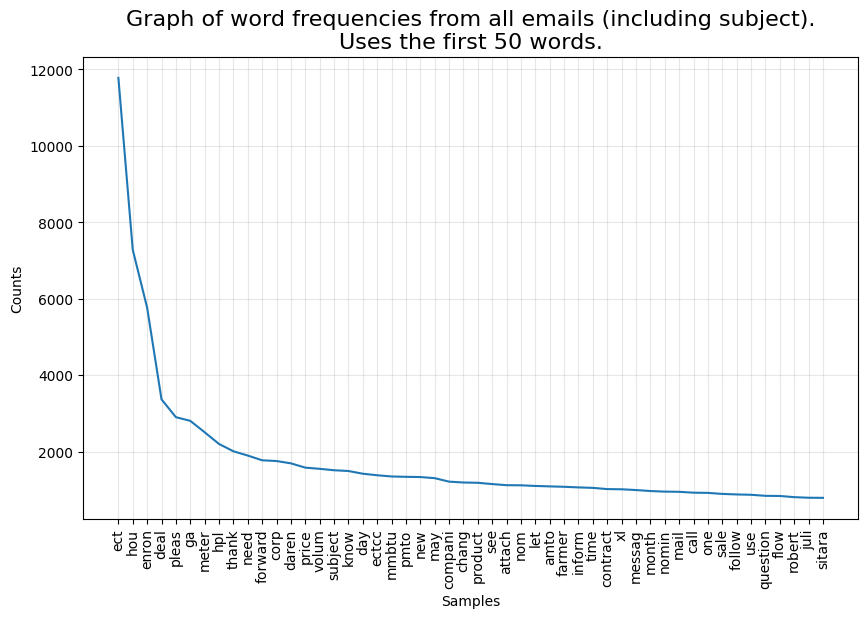

In [31]:
count_word = 50

fig, ax = plt.subplots(figsize = (10,6))

ax.set_title(f"Graph of word frequencies from all emails (including subject).\nUses the first {count_word} words.", fontsize=16)

ax.set_xlabel("Samples")
ax.set_ylabel("Counts")

ax.set_xticks(range(count_word))
ax.set_xticklabels(frequency_words_subject_text.index[0:count_word], rotation=90)
ax.grid(alpha = 0.3)

ax.plot(frequency_words_subject_text.index[0:count_word], frequency_words_subject_text['frequency'][0:count_word])

plt.show()

### Saving dataframes of word frequencies for Spam and Ham emails.

In [32]:
# frequency_words_ham_subject_text.to_csv('../dataset/model_data/frequency_words_ham_subject_text.csv')
# frequency_words_spam_subject_text.to_csv('../dataset/model_data/frequency_words_spam_subject_text.csv')

<hr>

### Preparing a dataframe of word frequencies.

#### Dropping words that occur fewer than 15 times.

In [33]:
print(f'Variety of words before dropping: {len(frequency_words_subject_text)}')
frequency_words_subject_text = frequency_words_subject_text[frequency_words_subject_text.frequency >= 15]
print(f'Variety of words after dropping: {len(frequency_words_subject_text)}')

Variety of words before dropping: 55352
Variety of words after dropping: 3199


#### Supplementing the frequency from the Ham and Spam email dataframe.

In [34]:
frequency_words_subject_text['frequency_ham'] = frequency_words_ham_subject_text['frequency']
frequency_words_subject_text['frequency_spam'] = frequency_words_spam_subject_text['frequency']

# Replacing NaN with 0
frequency_words_subject_text = frequency_words_subject_text.fillna(0)

# # Changing the data type of columns to int
frequency_words_subject_text['frequency_ham'] = frequency_words_subject_text['frequency_ham'].astype(int)
frequency_words_subject_text['frequency_spam'] = frequency_words_subject_text['frequency_spam'].astype(int)

frequency_words_subject_text

,frequency,frequency_ham,frequency_spam
ect,11780,11776,4
hou,7283,7279,4
enron,5768,5768,0
deal,3371,3272,99
pleas,2905,2465,440
...,...,...,...
loop,15,14,1
grab,15,5,10
conclud,15,6,9
unknown,15,7,8


##### Saving the dataframe of word frequencies.

In [35]:
frequency_words_subject_text.to_csv('../dataset/model_data/word_frequencies.csv')
frequency_words_subject_text

,frequency,frequency_ham,frequency_spam
ect,11780,11776,4
hou,7283,7279,4
enron,5768,5768,0
deal,3371,3272,99
pleas,2905,2465,440
...,...,...,...
loop,15,14,1
grab,15,5,10
conclud,15,6,9
unknown,15,7,8


<hr>